# Compare the previous compendia against the new one

The new compendia contains 29 additional SRX identifiers from sputum samples that were either recently published or that were not annotated as containing Pa and thus were excluded from the initial compendia. Both filtering and normalization are dependent on the entirety of samples, so each time a new sample is added, the exact values in the compendia will change. This notebook evaluates the magnitude of those changes with the addition of the 29 samples.

In [1]:
setwd("..")

In [107]:
# adjust plot size rendered inline
options(repr.plot.width = 7, repr.plot.height = 5, repr.plot.res = 200)

In [86]:
library(dplyr)
library(readr)
library(tibble)
library(ggplot2)
library(ggcorrplot)
library(vegan)

## Functions

In [24]:
hlog <- function(df, base=exp(1)){
  # Description: 'safely' tales the log of data replacing -Inf and Nan with 0
  # df: dataframe of gene expression to be logged
  # base: base for log calculation
  # returns: log of df with happy 0s for 0 or neg values
  dfl <- data.frame(log(data.matrix(df),base))
  dfl[dfl == -Inf] <- 0
  dfl[dfl < 0] <- 0
  dfl
}

## Read in data

In [ ]:
metadata <- read_csv("inputs/metadata.csv", show_col_types = F)

In [6]:
# read in original compendia
pa14_og <- read_csv("inputs/pa_compendia/Dataset_S4_PA14_compendium.gz", show_col_types = F) %>%
  rename(Name = "...1")
# fix original compendia names
colnames(pa14_og) <- gsub("\\..*", "", colnames(pa14_og))
# rean in new compendia
pa14_new <- read_csv("outputs/filt_norm_compendia/pa14_aligned_compendium_p2_filtered_counts_norm.csv", show_col_types = F) %>%
  rename(Name = "...1")

New names:
* `` -> ...1

New names:
* `` -> ...1



In [27]:
pa14_og_hlog <- hlog(pa14_og)
pa14_new_hlog <- hlog(pa14_new)

In [7]:
pa14_og[1:5, 1:5]
pa14_new[1:5, 1:5]

Name,ERX541571,ERX541572,ERX541573,ERX541574
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
PA14_55610,209.35317,223.627085,167.343061,203.038931
PA14_55600,55.65084,52.077540,44.624816,13.454387
PA14_55590,0.00000,6.126769,18.128832,6.115630
PA14_55580,2.65004,15.316924,23.706934,14.677513
PA14_55570,10.60016,21.443693,8.367153,4.892504


Name,ERX541571,ERX541572,ERX541573,ERX541574
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
PA14_55610,12.884224,14.531336,11.035213,13.165820
PA14_55600,9.663168,8.718802,7.356809,2.393785
PA14_55590,0.000000,2.906267,7.356809,3.590678
PA14_55580,1.610528,4.359401,8.582944,4.787571
PA14_55570,6.442112,13.078202,6.130674,3.590678


## Evaluate filtering

Did all of the samples that made it into the original compendia make it into the new compendia?

In [8]:
table(colnames(pa14_og) %in% colnames(pa14_new))


TRUE 
2334 

Did any new samples make it into the compendia, other than the 29 we added? (note many of the 29 appear to have been filtered out for low counts)

In [9]:
table(colnames(pa14_new) %in% colnames(pa14_og))


FALSE  TRUE 
   10  2334 

In [14]:
colnames(pa14_new)[!colnames(pa14_new) %in% colnames(pa14_og)]
colnames(pa14_new)[!colnames(pa14_new) %in% colnames(pa14_og)] %in% metadata$experiment_accession

[1] "ERX2326473" "SRX6981202" "SRX6981192" "SRX3789394" "SRX3789395"
 [6] "SRX3789396" "SRX3789390" "SRX3789391" "SRX7101182" "SRX7101183"

[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE

## Evaluate normalization: no hlog

In [16]:
# do the transcript names match between the two compendia (e.g. are they ordered the same)?
all.equal(pa14_new$Name, pa14_og$Name)

[1] TRUE

In [38]:
summary(lm(pa14_new$ERX541571 ~ pa14_og$ERX541571))


Call:
lm(formula = pa14_new$ERX541571 ~ pa14_og$ERX541571)

Residuals:
   Min     1Q Median     3Q    Max 
-50879    -61    -37    -31  53883 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)       33.375940  19.664926   1.697   0.0897 .  
pa14_og$ERX541571  0.332622   0.004188  79.427   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1491 on 5889 degrees of freedom
Multiple R-squared:  0.5172,	Adjusted R-squared:  0.5171 
F-statistic:  6309 on 1 and 5889 DF,  p-value: < 2.2e-16


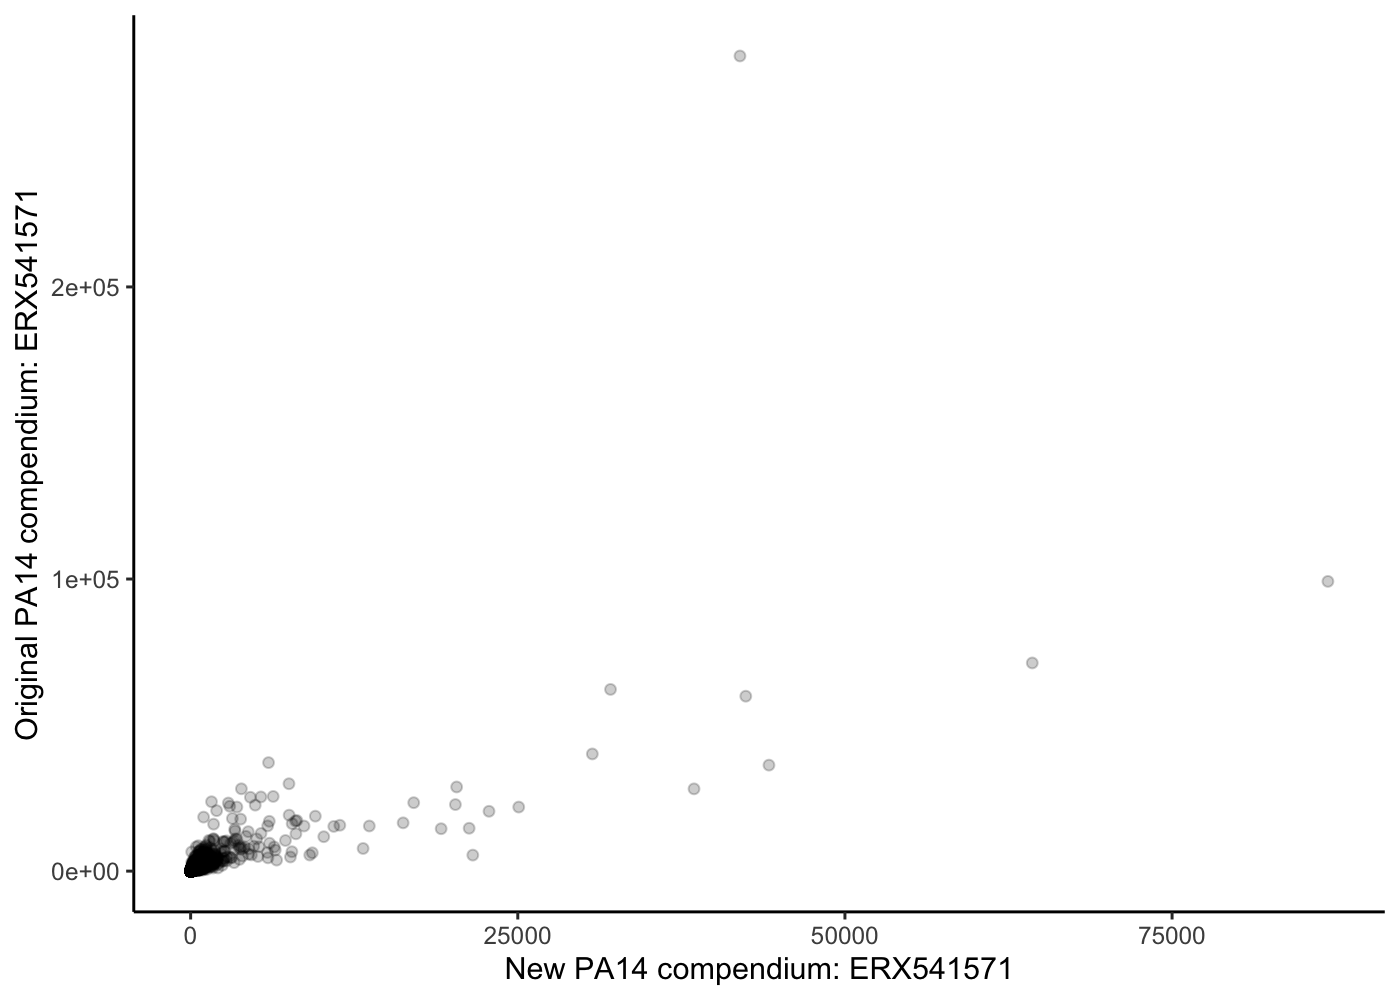

In [108]:
ggplot(data.frame(x = pa14_new$ERX541571, y = pa14_og$ERX541571), 
       aes(x, y)) +
  geom_point(alpha = .2) + 
  theme_classic() + 
  labs(x = "New PA14 compendium: ERX541571", y = "Original PA14 compendium: ERX541571")

### Mantel test on genes

In [34]:
pa14_new_dist <- dist(pa14_new[ , 2:ncol(pa14_og)])
pa14_og_dist <- dist(pa14_og[ , 2:ncol(pa14_og)])

In [35]:
mantel_res <- mantel(pa14_new_dist, pa14_og_dist, method = "spearman", permutations = 999, na.rm = TRUE)

In [36]:
mantel_res


Mantel statistic based on Spearman's rank correlation rho 

Call:
mantel(xdis = pa14_new_dist, ydis = pa14_og_dist, method = "spearman",      permutations = 999, na.rm = TRUE) 

Mantel statistic r: 0.8177 
      Significance: 0.001 

Upper quantiles of permutations (null model):
   90%    95%  97.5%    99% 
0.0137 0.0179 0.0206 0.0248 
Permutation: free
Number of permutations: 999


### Mantel test on samples

In [58]:
pa14_new_sample_dist <- pa14_new %>%
  select(-ERX2326473, -SRX6981202, -SRX6981192, -SRX3789394, -SRX3789395, 
         -SRX3789396, -SRX3789390, -SRX3789391, -SRX7101182, -SRX7101183) %>% # remove newly computed samples
  column_to_rownames("Name") %>%
  t() %>%
  dist()

pa14_og_sample_dist <- pa14_og %>%
  column_to_rownames("Name") %>%
  t() %>%
  dist()

In [59]:
mantel_sample_res <- mantel(pa14_new_sample_dist, pa14_og_sample_dist, 
                            method = "spearman", permutations = 999, na.rm = TRUE)

In [60]:
mantel_sample_res


Mantel statistic based on Spearman's rank correlation rho 

Call:
mantel(xdis = pa14_new_sample_dist, ydis = pa14_og_sample_dist,      method = "spearman", permutations = 999, na.rm = TRUE) 

Mantel statistic r: 0.7304 
      Significance: 0.001 

Upper quantiles of permutations (null model):
   90%    95%  97.5%    99% 
0.0223 0.0295 0.0344 0.0416 
Permutation: free
Number of permutations: 999


### Dimensionality reduction

In [65]:
prcomp_pa14_new <- pa14_new %>%
  select(-ERX2326473, -SRX6981202, -SRX6981192, -SRX3789394, -SRX3789395, 
         -SRX3789396, -SRX3789390, -SRX3789391, -SRX7101182, -SRX7101183) %>% # remove newly computed samples
  column_to_rownames("Name") %>%
  t() %>%
  prcomp()

prcomp_pa14_og <- pa14_og %>%
  column_to_rownames("Name") %>%
  t() %>%
  prcomp()

In [66]:
summary(lm(prcomp_pa14_new$x[ , 1] ~ prcomp_pa14_og$x[ , 1]))


Call:
lm(formula = prcomp_pa14_new$x[, 1] ~ prcomp_pa14_og$x[, 1])

Residuals:
    Min      1Q  Median      3Q     Max 
 -66486  -17943  -12110     761 1079987 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)           7.145e-12  1.086e+03   0.000        1    
prcomp_pa14_og$x[, 1] 7.359e-02  1.785e-02   4.123 3.86e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 52480 on 2331 degrees of freedom
Multiple R-squared:  0.007242,	Adjusted R-squared:  0.006816 
F-statistic:    17 on 1 and 2331 DF,  p-value: 3.862e-05


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC1.1,PC2.1,PC3.1,PC4.1,PC5.1,PC6.1,PC7.1,PC8.1,PC9.1,PC10.1
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ERX541571,-22320.64,29839.24,-74550.04,67001.14,-20959.981,10476.178,-44250.92,22890.59,-59631.18,17840.10,-20694.12,14276.523,-59579.54,44958.58,-16677.119,53641.13,-18523.25,90845.31,-54195.32,99257.89
ERX541572,-18146.01,21292.77,-64593.75,64069.22,-14208.726,7957.658,-45729.20,23599.99,-61674.63,18597.08,-18257.36,1638.383,-59557.27,32255.55,-6371.945,49195.48,-18401.03,78651.44,-42151.14,85555.98
ERX541573,-15744.87,20997.16,-54401.10,50528.52,-9713.456,1832.907,-47719.23,25202.23,-64523.35,21020.04,-14562.95,-30856.249,-52904.19,21853.42,-3844.479,35217.15,-16303.55,58930.94,-23581.88,52847.98
ERX541574,-15936.65,21155.70,-55872.39,53566.08,-11544.948,3677.765,-52080.36,25637.21,-73236.45,23023.69,-15371.06,-28560.690,-51845.93,28556.75,-9273.807,38460.02,-18453.63,74554.59,-31932.18,66861.08
ERX541575,-16080.57,24315.85,-64107.12,60605.25,-15440.566,3432.260,-50977.74,25524.68,-71399.41,22132.36,-16565.46,-18867.168,-52394.71,26179.72,-6446.583,38578.57,-18662.76,70562.28,-32643.18,63839.85
ERX541576,-19033.71,25607.60,-70171.66,67429.31,-17604.719,5545.689,-53086.77,26451.08,-77779.49,22032.49,-13921.71,-12074.904,-52035.51,28724.12,-10200.288,38768.48,-19984.84,77289.89,-39486.95,68904.77


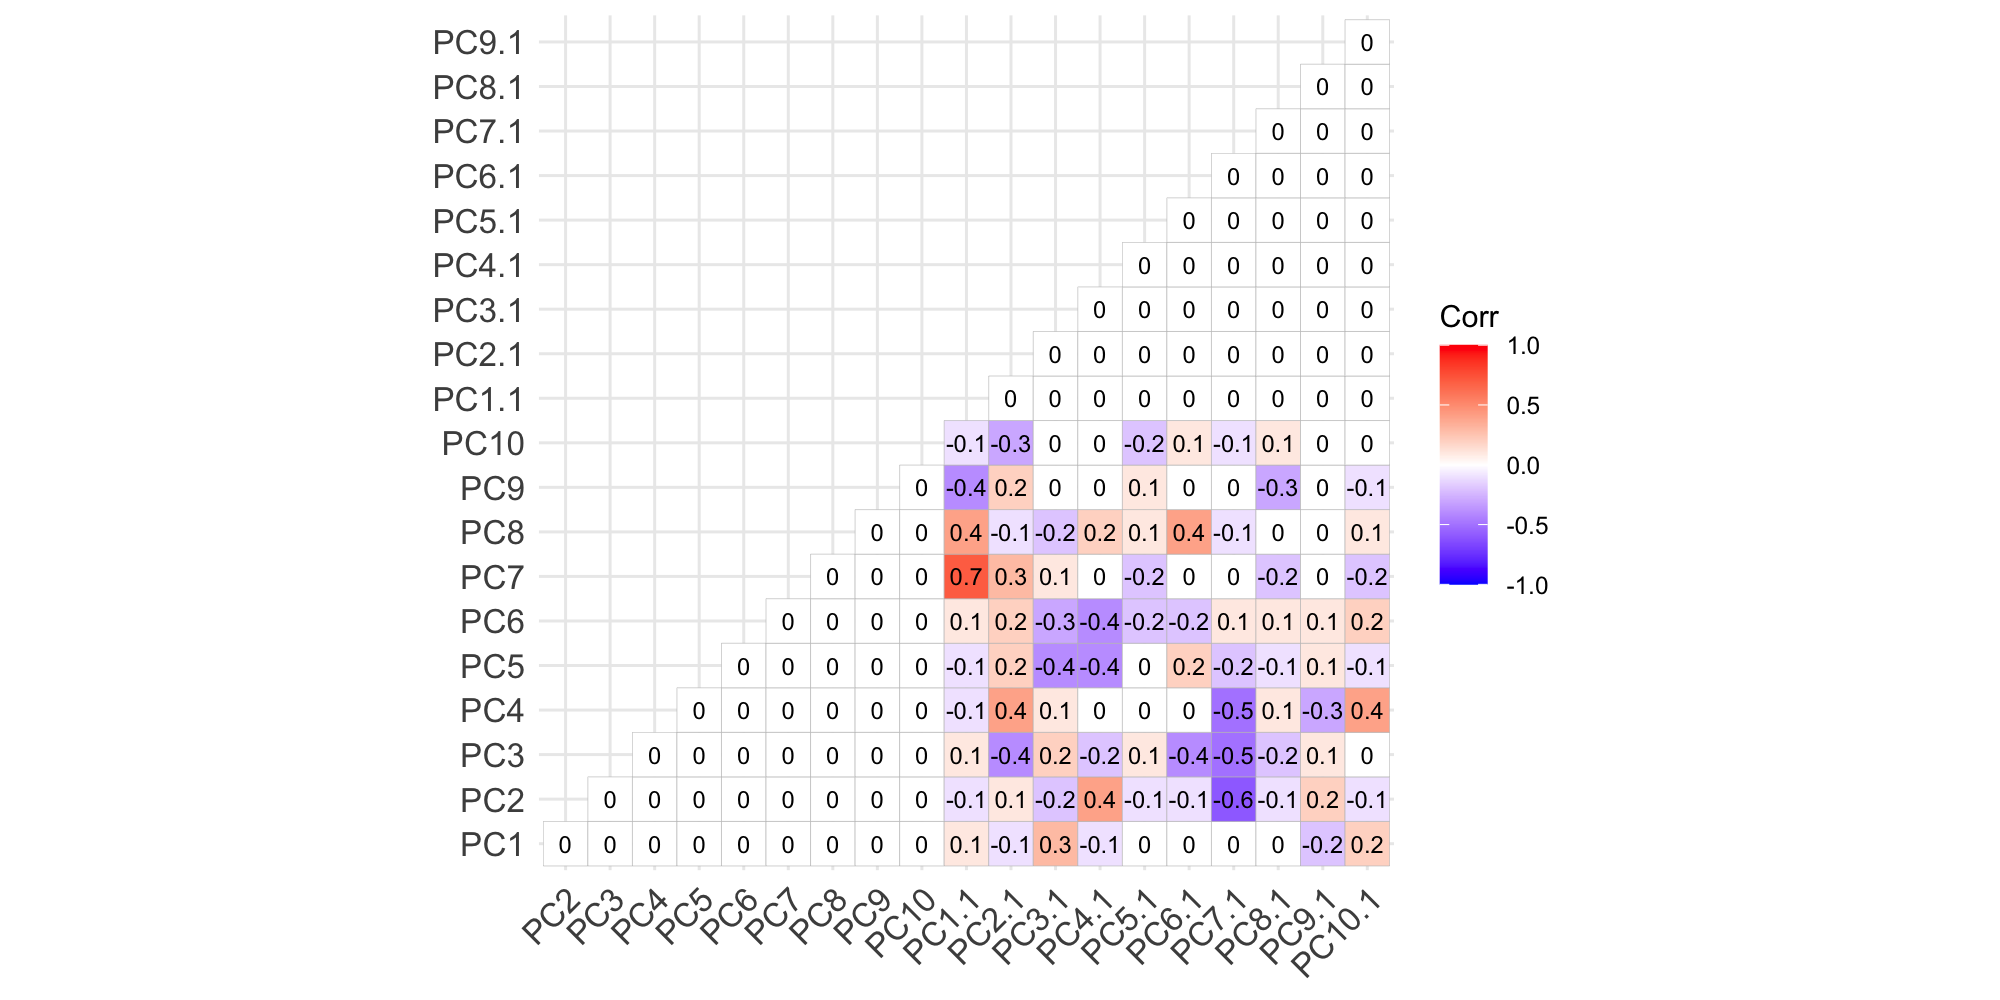

In [101]:
df <- data.frame(prcomp_pa14_new$x[ , 1:10], prcomp_pa14_og$x[ , 1:10])
head(df)
tmp <- cor(df)
ggcorrplot(tmp, type = "lower", lab = T, digits = 1, lab_size = 3)

## Evaluate normalization: hlog

### simple lineaer regression for one samples

In [39]:
summary(lm(pa14_new_hlog$ERX541571 ~ pa14_og_hlog$ERX541571))


Call:
lm(formula = pa14_new_hlog$ERX541571 ~ pa14_og_hlog$ERX541571)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.9568 -0.4399 -0.0653  0.4648  3.1931 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)            -0.513802   0.020472   -25.1   <2e-16 ***
pa14_og_hlog$ERX541571  0.847842   0.004069   208.3   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.6472 on 5889 degrees of freedom
Multiple R-squared:  0.8805,	Adjusted R-squared:  0.8805 
F-statistic: 4.341e+04 on 1 and 5889 DF,  p-value: < 2.2e-16


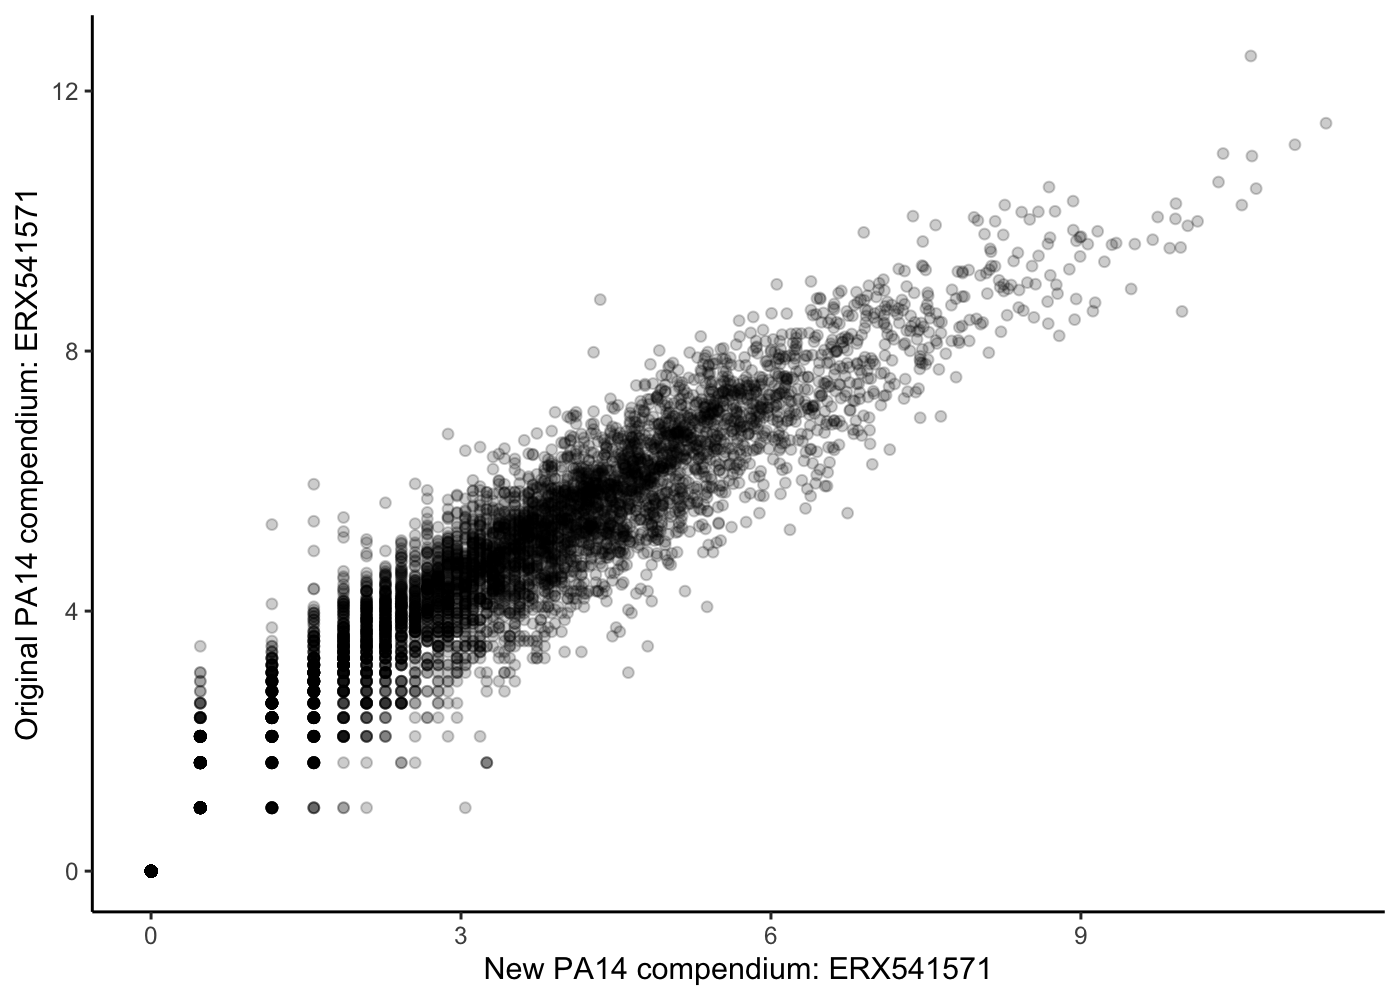

In [109]:
ggplot(data.frame(x = pa14_new_hlog$ERX541571, y = pa14_og_hlog$ERX541571), 
       aes(x, y)) +
  geom_point(alpha = .2) + 
  theme_classic() + 
  labs(x = "New PA14 compendium: ERX541571", y = "Original PA14 compendium: ERX541571")

### mantel test on gene values

In [40]:
pa14_new_hlog_dist <- dist(pa14_new_hlog[ , 2:ncol(pa14_og_hlog)])
pa14_og_hlog_dist <- dist(pa14_og_hlog[ , 2:ncol(pa14_og_hlog)])

In [41]:
mantel_hlog_res <- mantel(pa14_new_hlog_dist, pa14_og_hlog_dist, method = "spearman", permutations = 999, na.rm = TRUE)

In [42]:
mantel_hlog_res


Mantel statistic based on Spearman's rank correlation rho 

Call:
mantel(xdis = pa14_new_hlog_dist, ydis = pa14_og_hlog_dist, method = "spearman",      permutations = 999, na.rm = TRUE) 

Mantel statistic r: 0.8324 
      Significance: 0.001 

Upper quantiles of permutations (null model):
    90%     95%   97.5%     99% 
0.00819 0.01111 0.01258 0.01486 
Permutation: free
Number of permutations: 999


### mantel test on samples

In [54]:
pa14_new_hlog_sample_dist <- pa14_new_hlog %>%
  select(-ERX2326473, -SRX6981202, -SRX6981192, -SRX3789394, -SRX3789395, 
         -SRX3789396, -SRX3789390, -SRX3789391, -SRX7101182, -SRX7101183) %>% # remove newly computed samples
  column_to_rownames("Name") %>%
  t() %>%
  dist()

pa14_og_hlog_sample_dist <- pa14_og_hlog %>%
  column_to_rownames("Name") %>%
  t() %>%
  dist()

In [55]:
mantel_hlog_sample_res <- mantel(pa14_new_hlog_sample_dist, pa14_og_hlog_sample_dist, 
                                 method = "spearman", permutations = 999, na.rm = TRUE)

In [56]:
mantel_hlog_sample_res


Mantel statistic based on Spearman's rank correlation rho 

Call:
mantel(xdis = pa14_new_hlog_sample_dist, ydis = pa14_og_hlog_sample_dist,      method = "spearman", permutations = 999, na.rm = TRUE) 

Mantel statistic r: 0.9745 
      Significance: 0.001 

Upper quantiles of permutations (null model):
   90%    95%  97.5%    99% 
0.0130 0.0165 0.0192 0.0228 
Permutation: free
Number of permutations: 999


### dimensionality reduction plots

In [57]:
prcomp_pa14_new_hlog <- pa14_new_hlog %>%
  select(-ERX2326473, -SRX6981202, -SRX6981192, -SRX3789394, -SRX3789395, 
         -SRX3789396, -SRX3789390, -SRX3789391, -SRX7101182, -SRX7101183) %>% # remove newly computed samples
  column_to_rownames("Name") %>%
  t() %>%
  prcomp()

prcomp_pa14_og_hlog <- pa14_og_hlog %>%
  column_to_rownames("Name") %>%
  t() %>%
  prcomp()

In [64]:
summary(lm(prcomp_pa14_new_hlog$x[ , 1] ~ prcomp_pa14_og_hlog$x[ , 1]))


Call:
lm(formula = prcomp_pa14_new_hlog$x[, 1] ~ prcomp_pa14_og_hlog$x[, 
    1])

Residuals:
     Min       1Q   Median       3Q      Max 
-13.6348  -3.6083  -0.4425   3.0726  19.7084 

Coefficients:
                             Estimate Std. Error t value Pr(>|t|)    
(Intercept)                -5.597e-15  1.089e-01     0.0        1    
prcomp_pa14_og_hlog$x[, 1] -8.966e-01  2.657e-03  -337.4   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 5.259 on 2331 degrees of freedom
Multiple R-squared:  0.9799,	Adjusted R-squared:  0.9799 
F-statistic: 1.138e+05 on 1 and 2331 DF,  p-value: < 2.2e-16


In [103]:
df <- data.frame(prcomp_pa14_new_hlog$x[ , 1:10], prcomp_pa14_og_hlog$x[ , 1:10])
head(df)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC1.1,PC2.1,PC3.1,PC4.1,PC5.1,PC6.1,PC7.1,PC8.1,PC9.1,PC10.1
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ERX541571,-6.260607,-24.06255,-46.76658,4.1982808,-4.649906,7.5553219,-12.37377,-10.904599,11.485973,-2.513773,-0.3239612,-21.27113,37.35233,-34.37421,0.6241714,-11.306935,5.051555,-15.92248,2.122784,-15.91776
ERX541572,-3.357908,-23.70702,-44.54079,5.2912668,-6.710177,4.8507255,-10.82227,-10.871886,10.503777,-5.294532,-4.3904956,-20.28883,34.70264,-34.54137,-1.7243148,-8.897083,5.675509,-15.21100,4.315651,-16.27028
ERX541573,-2.174332,-23.09783,-38.12382,-0.8943821,-4.172980,-0.5606225,-14.92583,-11.061630,13.792954,-7.066395,-6.0420764,-21.53455,32.66268,-25.05164,-0.1536273,-6.344578,11.596213,-16.36263,4.282373,-19.14155
ERX541574,-2.478469,-23.50679,-38.48874,-0.9763183,-4.963811,-0.8500383,-15.50658,-10.451087,12.345522,-9.388093,-4.1859632,-23.04824,33.53570,-24.47852,0.4130176,-9.298015,13.444827,-16.08886,5.936080,-18.40644
ERX541575,-5.041117,-22.66585,-39.49413,-0.4164599,-3.918862,1.2558713,-14.68501,-9.622375,9.909197,-7.549715,-3.0315745,-20.18285,32.85787,-26.36710,0.4972755,-7.803237,10.499844,-15.22151,5.770176,-15.92246
ERX541576,-8.233365,-22.65842,-39.21012,-1.3741179,-4.024187,0.2076857,-14.08330,-10.516219,9.825166,-7.815146,1.4245811,-21.20429,34.02581,-25.16177,0.2236043,-7.386181,10.640574,-15.80146,5.790836,-15.50647


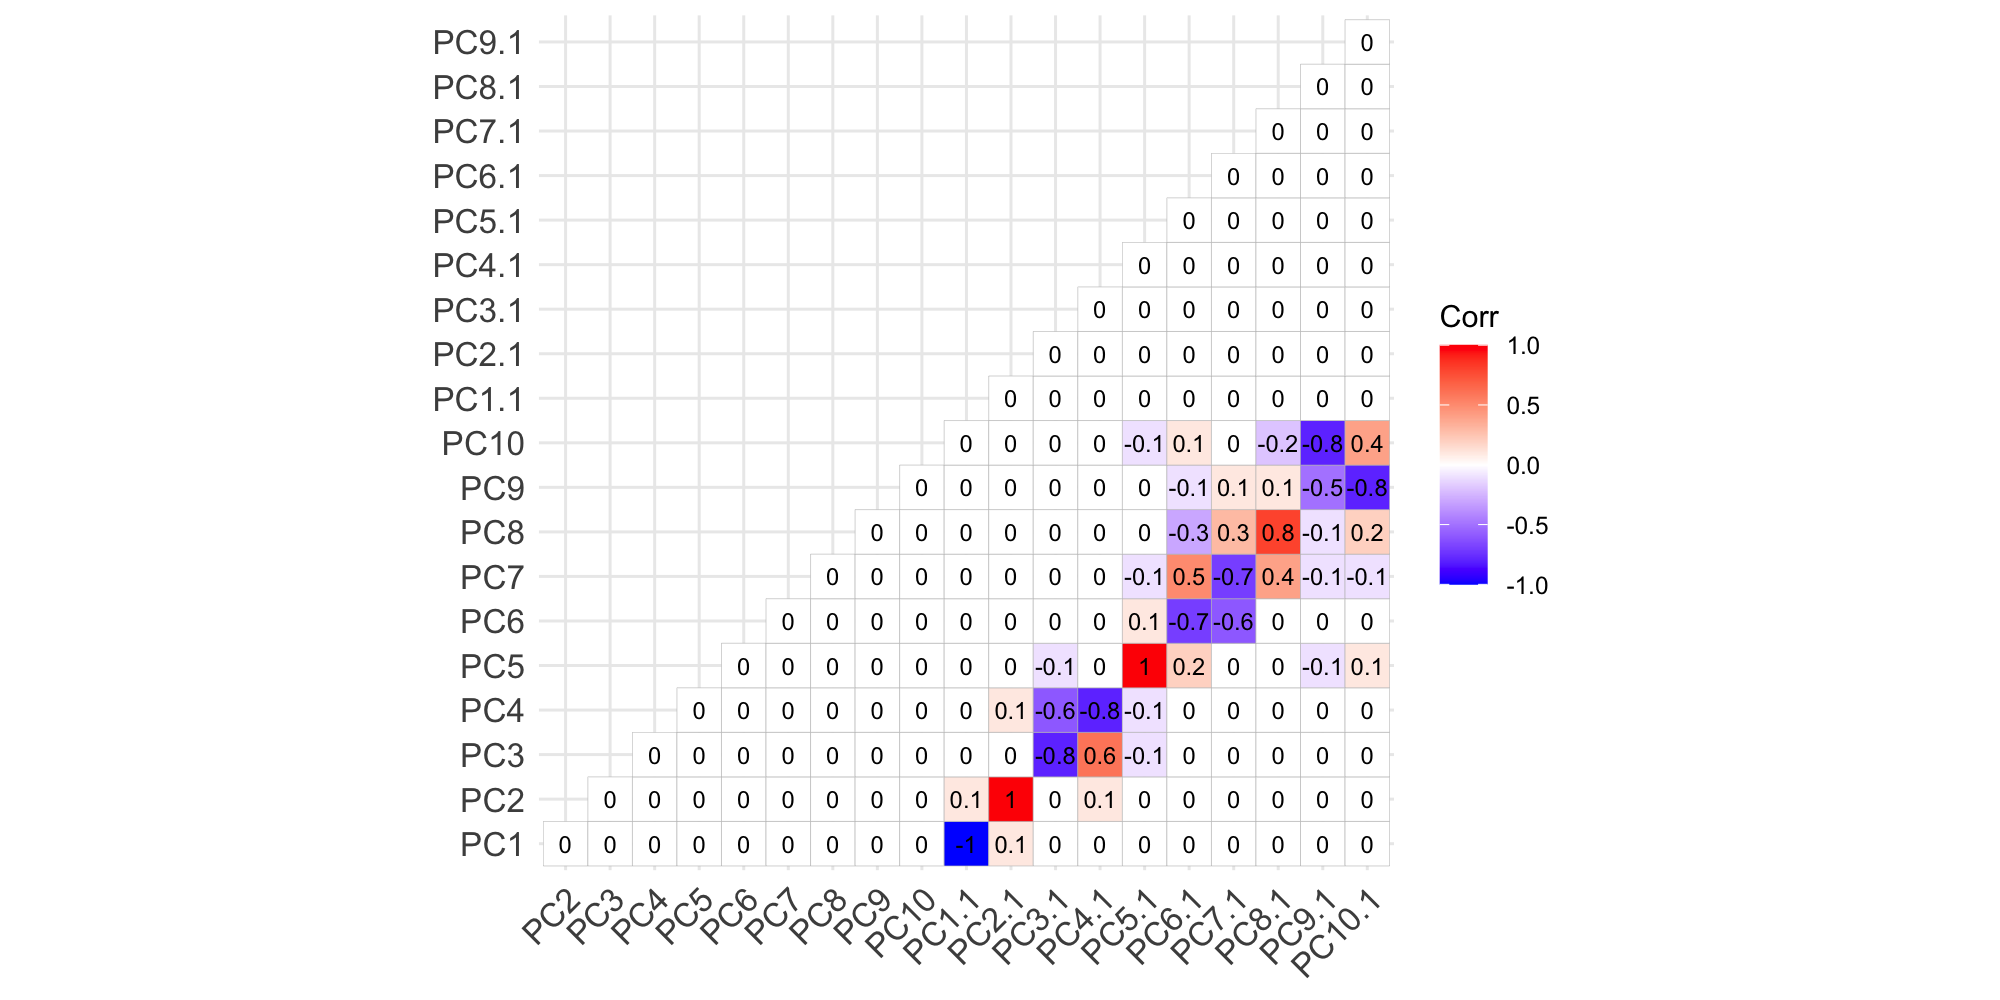

In [104]:
tmp <- cor(df)
ggcorrplot(tmp, type = "lower", lab = T, digits = 1, lab_size = 3)